In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1)

Lien vers le prototype du modèle: https://risk-modeling-app.herokuapp.com

Objectif: 

- Developper un modèle permettant d'estimer la probalité d'un defaut de paiement.
- La metrique cible que l'on souhaite optimiser est le `recall` de la classe positif i.e la capacité du modèle à détecter les défauts de paiement tout en minisant les faux negatifs car ces derniers representent un manque à gagner.

Definition du risque crédit:

`Analyser le risque de crédit d’un agent économique c’est chercher à définir la probabilité de perte sur une créance de cet agent ou de défaillance globale de cet agent en tant qu’émetteur de dette.`

source: https://nicolasfinot.com/analyse-et-gestion-du-risque-de-credit/

On dispose d'un dataset répertoriant l'historique de plus de 30k crédit octroyés.
Pour chaque crédit on dispose des informations suivantes:

**Variables explicatives**

Les variables explicatives se décompose en deux parties. 
- variables décrivant le demandeur de crédit
    - person_age: age de du demandeur au moment de la demande de credit.
    - person_income: revenues du demandeur du crédit.
    - person_home_ownership: possède t-il un logement? est-il propriétaire/crédit en cours/location
    - cb_person_cred_hist_length: nombre de credit emprunter par le passé
    - cb_person_default_on_file: variable binaire qui specifie si le client à déjà présenté un defaut de paiement par le passé.
    
    
    
- variables décrivant sa demande
    - loan_intent: la raison pour laquelle le prêt à été contracter.
    - load_grade: Note sur le risque que présente le profil du débiteur.
    - loan_amnt: montant de l'emprunt
    - loan_int_rate: taux d'intérêt.

**Cible à prédire**

loan_status: égale 1 lorsqu'il y'a eu un défaut de paiement.

In [55]:
loans = pd.read_csv('input/loans.csv')

In [56]:
loans.sample(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1152,23,85500,RENT,1.0,EDUCATION,C,17000,13.11,0,0.20,Y,2
10055,25,59000,MORTGAGE,9.0,EDUCATION,B,20000,11.36,1,0.34,N,2
32017,36,130000,MORTGAGE,9.0,MEDICAL,B,12000,NaN,0,0.09,N,14
5457,22,58380,RENT,2.0,VENTURE,C,5000,12.29,0,0.09,N,3
39,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.42,N,4
23345,29,62000,OWN,4.0,EDUCATION,A,15000,6.03,0,0.24,N,7
19044,35,70000,RENT,2.0,EDUCATION,C,2000,13.72,0,0.03,N,7
9123,21,35368,RENT,0.0,DEBTCONSOLIDATION,C,5100,12.99,0,0.14,N,2
24163,27,70000,MORTGAGE,11.0,DEBTCONSOLIDATION,A,1000,6.54,0,0.01,N,5
31521,41,180000,RENT,16.0,DEBTCONSOLIDATION,A,14000,6.03,0,0.08,N,15


## Analyse descriptive

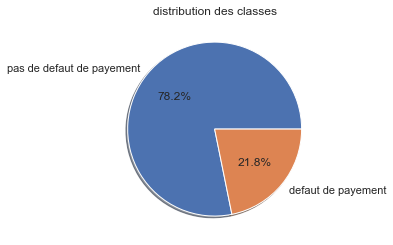

In [5]:
plt.figure()
ax = plt.axes()
ax.pie(loans.loan_status.value_counts(),
       labels=['pas de defaut de paiement', 'defaut de paiement'],
       autopct='%1.1f%%',
       shadow=True
)
plt.title('distribution des classes')
plt.show()

Regardons l'ensemble des columns et essayons d'identifier le type de variable. S'agit-il de variable de categorie ou d'une variable numérique? existe-t-il des valeurs extremes? 

## person_age

Cette variable décrit l'age du débiteur.  

In [6]:
loans[['person_age']].describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.7346,6.348078,20.0,23.0,26.0,30.0,144.0


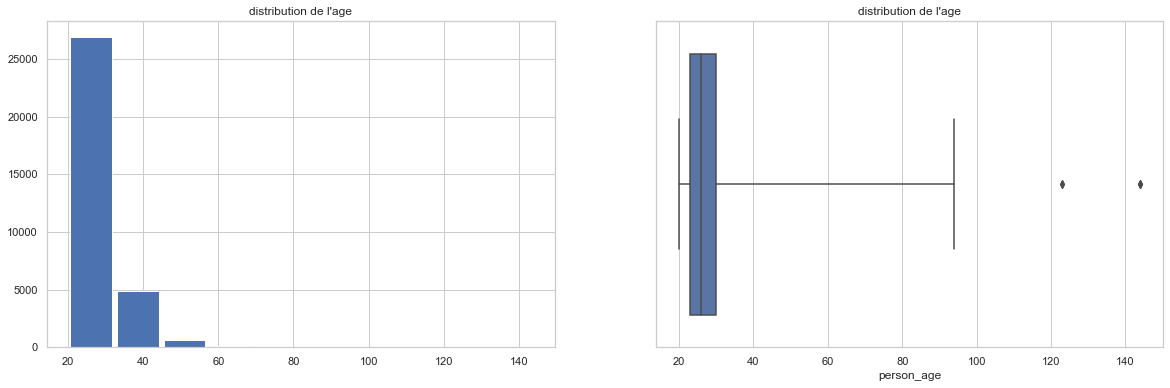

In [7]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.hist(loans.person_age, rwidth=.9)
plt.title("distribution de l'age")

plt.subplot(1,2,2)
sns.boxplot(loans.person_age, whis=10)
plt.title("distribution de l'age")

plt.show()

In [8]:
loans[loans.person_age>100]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


C'est peu commun qu'une personne agée de plus 100ans fasse une demande de crédit. 
On peut donc supprimer ces échantillons.

In [9]:
loans = loans[~(loans.person_age>100)]

Quelle est la tranche d'age qui fait le plus de demande de credit? Quel est le pourcentage de defaut de paiement par tranche d'age?

In [10]:
age_data, bins = pd.cut(loans.person_age, 10, retbins=True, precision=0)
age_ct = pd.crosstab(age_data, loans.loan_status)
age_ct['total_demande'] = age_ct.sum(axis=1)
age_ct['defaut-de-payement-prop'] = age_ct[1].div(age_ct.total_demande)
age_ct.sort_values('total_demande', ascending=False)

loan_status,0,1,total_demande,defaut-de-payement-prop
person_age,,,,
"(20.0, 27.0]",15471,4496,19967,0.225172
"(27.0, 35.0]",6771,1757,8528,0.206027
"(35.0, 42.0]",2393,628,3021,0.207878
"(42.0, 50.0]",583,142,725,0.195862
"(50.0, 57.0]",173,58,231,0.251082
"(57.0, 64.0]",46,19,65,0.292308
"(64.0, 72.0]",23,8,31,0.258065
"(72.0, 79.0]",5,0,5,0.000000
"(79.0, 87.0]",2,0,2,0.000000


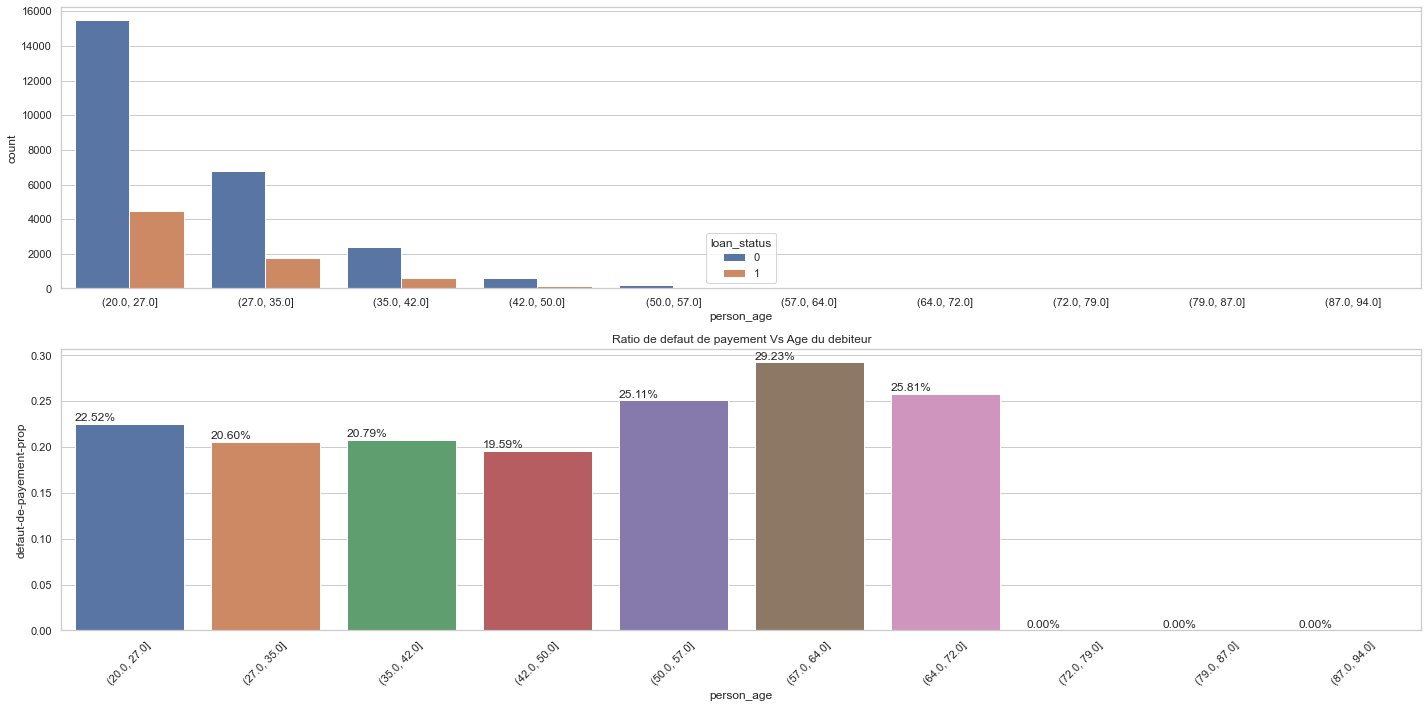

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))

sns.countplot(age_data, hue=loans.loan_status, ax=ax1)
plt.xticks(rotation=45)
plt.title('Total de demande Vs Age du debiteur')


sns.barplot(age_ct.index, age_ct['defaut-de-payement-prop'], ax=ax2)
plt.xticks(rotation=45)
plt.title('Ratio de defaut de paiementpayement Vs Age du debiteur')

for p in ax2.patches:
    h = p.get_height()
    ax2.text(p.get_x(), h+0.003, f"{h:.2%}")

plt.tight_layout()
plt.show()

- Les 20-27ans enregistre le plus de demande de crédit. 
- Les 57-64ans présente un plus gros risque de défaut de payement avec un peu moins d'un debiteur sur trois (~30%) qui présente un defaut de payement.

## person_income

Cette variable decrit le total des revenues du débiteur.

In [12]:
loans[['person_income']].describe().T

,count,mean,std,min,25%,50%,75%,max
person_income,32576.0,65882.14127,52534.987497,4000.0,38500.0,55000.0,79200.0,2039784.0


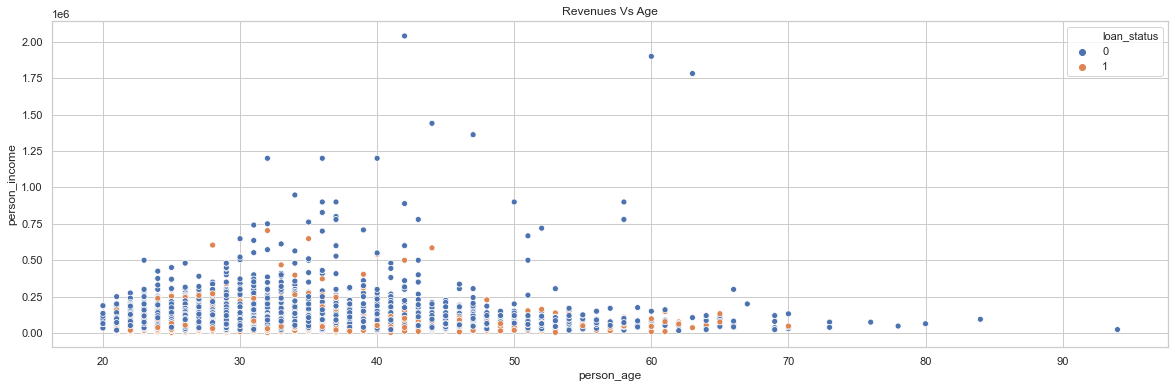

In [13]:
plt.figure(figsize=(20,6))
plt.title('Revenues Vs Age')
sns.scatterplot(loans.person_age, loans.person_income, hue=loans.loan_status)
plt.show()

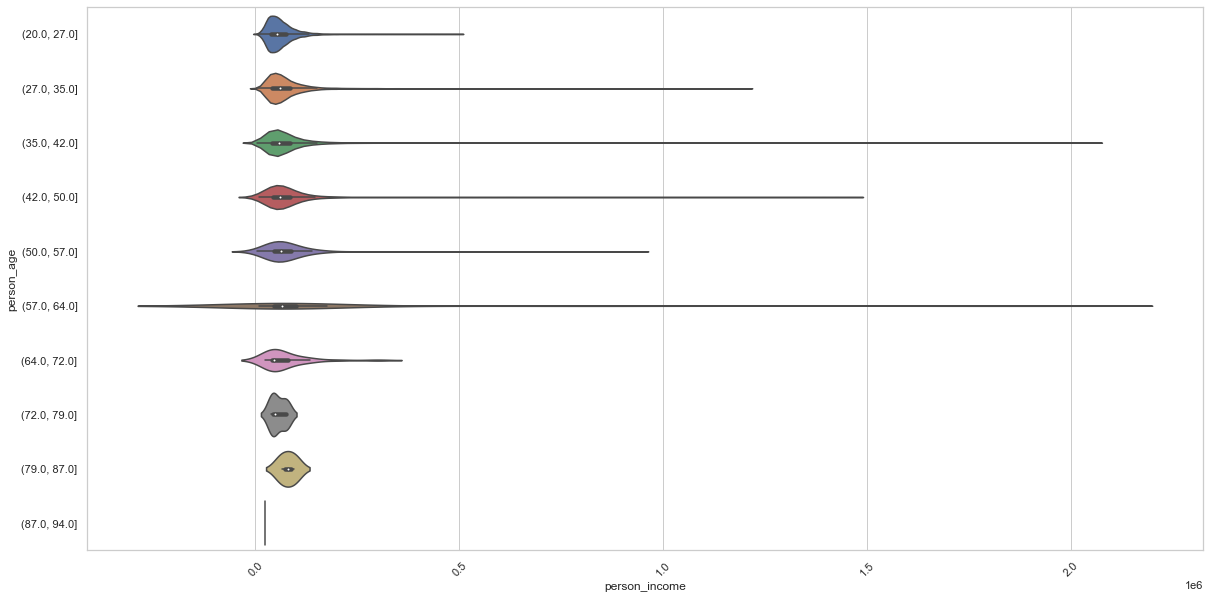

In [14]:
plt.figure(figsize=(20, 10))
sns.violinplot(loans.person_income, age_data)
plt.xticks(rotation=45)
plt.show()

- Les personnes qui gagne plus `~750k$` ne présentent généralement pas de défaut de payement.

Quel est le revenue moyenne des personnes en defaut de payement?

In [15]:
loans[loans.loan_status==1]['person_income'].mean(), loans[loans.loan_status==0]['person_income'].mean()

(49125.65222284749, 70558.79919899482)

- Les personnes qui présentent un defaut de payement gagnent en moyenne `~50k$`.
- Les bons debiteurs sans défaut de payement gagnent en moyenne `~70k$`.


## person_home_ownership

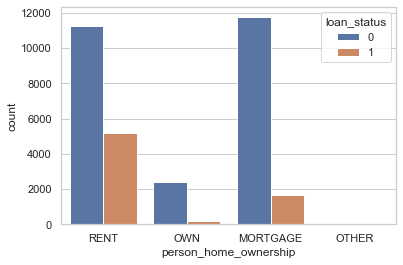

In [16]:
plt.figure()
sns.countplot(loans.person_home_ownership, hue=loans.loan_status)
plt.show()

In [17]:
ct = pd.crosstab(loans.person_home_ownership, age_data)
ct

person_age,"(20.0, 27.0]","(27.0, 35.0]","(35.0, 42.0]","(42.0, 50.0]","(50.0, 57.0]","(57.0, 64.0]","(64.0, 72.0]","(72.0, 79.0]","(79.0, 87.0]","(87.0, 94.0]"
person_home_ownership,,,,,,,,,,
MORTGAGE,7931,3792,1244,357,82,25,9,1,1,0
OTHER,76,18,7,6,0,0,0,0,0,0
OWN,1566,665,278,52,18,5,0,0,0,0
RENT,10394,4053,1492,310,131,35,22,4,1,1


In [18]:
ct.loc['prop_OWN'] = round(ct.loc['OWN']*100/ct.sum(axis=0),2)
ct.loc['prop_MORTGAGE'] = round(ct.loc['MORTGAGE']*100/ct.sum(axis=0),2)
ct.loc['prop_RENT'] = round(ct.loc['RENT']*100/ct.sum(axis=0),2)
ct

person_age,"(20.0, 27.0]","(27.0, 35.0]","(35.0, 42.0]","(42.0, 50.0]","(50.0, 57.0]","(57.0, 64.0]","(64.0, 72.0]","(72.0, 79.0]","(79.0, 87.0]","(87.0, 94.0]"
person_home_ownership,,,,,,,,,,
MORTGAGE,7931.00,3792.00,1244.00,357.00,82.00,25.00,9.00,1.0,1.00,0.0
OTHER,76.00,18.00,7.00,6.00,0.00,0.00,0.00,0.0,0.00,0.0
OWN,1566.00,665.00,278.00,52.00,18.00,5.00,0.00,0.0,0.00,0.0
RENT,10394.00,4053.00,1492.00,310.00,131.00,35.00,22.00,4.0,1.00,1.0
prop_OWN,7.84,7.80,9.20,7.17,7.79,7.69,0.00,0.0,0.00,0.0
prop_MORTGAGE,39.70,44.42,41.05,48.76,34.34,34.39,29.03,20.0,50.00,0.0
prop_RENT,51.93,47.24,48.58,39.70,47.96,32.69,36.65,16.0,1.92,100.0


## person_emp_length

In [19]:
loans[['person_emp_length']].describe().T

,count,mean,std,min,25%,50%,75%,max
person_emp_length,31681.0,4.789527,4.142706,0.0,2.0,4.0,7.0,123.0


On peut constater à partir des statistics ci-dessus qu'il existe surement quelque outliers. 

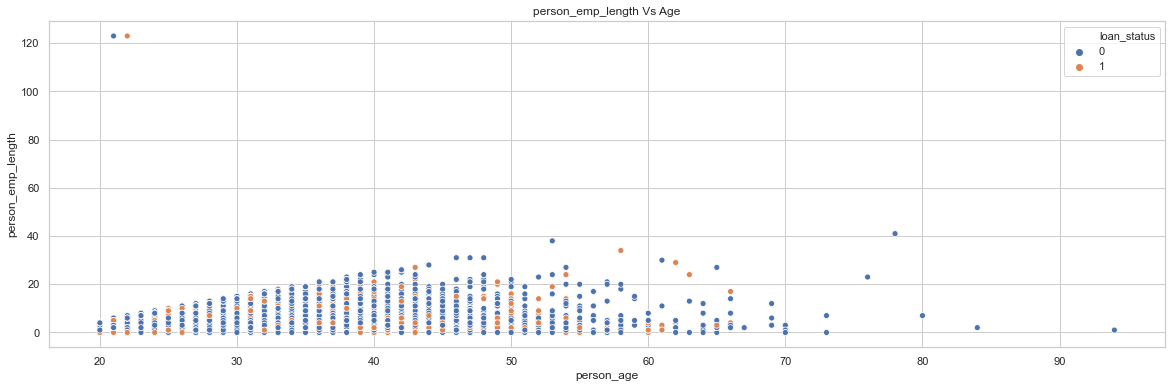

In [20]:
plt.figure(figsize=(20,6))
plt.title('person_emp_length Vs Age')
sns.scatterplot(loans.person_age, loans.person_emp_length, hue=loans.loan_status)
plt.show()

- Selon notre dataset la plupart des valeurs `person_emp_length` evolues entre 0 et 60.
- Deux points sortent de l'ordinaire, ils concernent deux debiteurs agés entre 20 et 25ans et la valeur de `person_emp_length` dépasse 100.

In [21]:
loans = loans[loans.person_emp_length<100]

## loan_intent

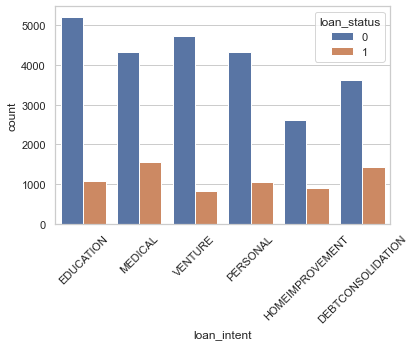

In [22]:
plt.figure()
sns.countplot(loans.loan_intent, hue=loans.loan_status)
plt.xticks(rotation=45)
plt.show()

## loan_grade

Variable ordinal, il s'agit d'un système de notation du risque crédit. Un debiteur noté `B`présente plus de risque d'insoulvabilité qu'un debiteur noté `A`.

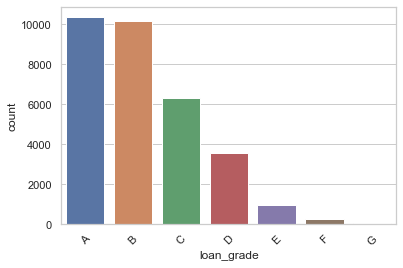

In [23]:
plt.figure()
sns.countplot(loans.loan_grade.sort_values())
plt.xticks(rotation=45)
plt.show()

On vois que malgré leur notation trés mauvaise certains prêts ont tout de même étaient accordés.

In [24]:
ct = pd.crosstab(loans.loan_grade, loans.loan_status)
ct['prop_defaut_payement'] = ct[1]/ct.sum(axis=1)
ct

loan_status,0,1,prop_defaut_payement
loan_grade,,,
A,9379,991,0.095564
B,8561,1622,0.159285
C,5036,1283,0.203038
D,1466,2089,0.587623
E,341,611,0.641807
F,70,166,0.703390
G,1,63,0.984375


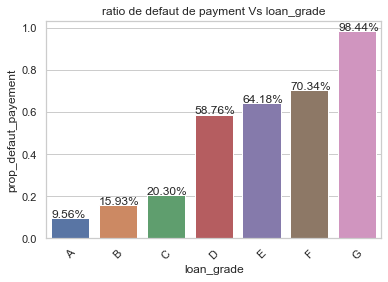

In [25]:
plt.figure()
ax = plt.axes()
plt.title('ratio de defaut de payment Vs loan_grade')
sns.barplot(ct.index, ct['prop_defaut_payement'])
plt.xticks(rotation=45)

for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x(), h+0.003, f"{h:.2%}")
    
plt.show()

- On contate que ~99% des demandes de crédit accordé noté `G` presentent un defaut de payement.
- Les defauts de payement est fortement correlé avec la note attribué par les analystes risques. 
- Les banques doivent faire plus souvent confiance à leur analyste risque. 

## loan_amnt
Cette varaible décrit le montant de l'emprunt.

In [26]:
loans[['loan_amnt']].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,31679.0,9659.962436,6334.360554,500.0,5000.0,8000.0,12500.0,35000.0


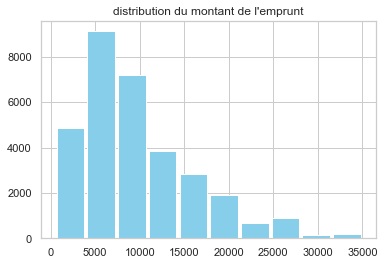

In [27]:
plt.figure()
plt.title("distribution du montant de l'emprunt")
plt.hist(loans.loan_amnt, rwidth=.9, color='skyblue')
plt.show()

Quel est le montant de l'emprunt moyenne des debiteur en defaut de payement et des bons debiteur?

In [28]:
(loans[loans.loan_status==1]['loan_amnt'].mean() - loans[loans.loan_status==0]['loan_amnt'].mean())/loans[loans.loan_status==0]['loan_amnt'].mean()

0.1861062504997221

Les debiteurs en defaut de payement emprunt un montant en moyenne `18.6%` superieur à celui des bons debiteurs.

## loan_int_rate
Cette variable represente le taux d'interêt de l'emprunt.

In [29]:
loans[['loan_int_rate']].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_int_rate,28632.0,11.039701,3.229409,5.42,7.9,10.99,13.48,23.22


/Users/brahimbizankad/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/brahimbizankad/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


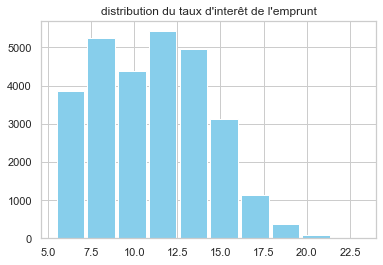

In [30]:
plt.figure()
plt.title("distribution du taux d'interêt de l'emprunt")
plt.hist(loans.loan_int_rate, rwidth=.9, color='skyblue', bins=10)
plt.show()

## loan_percent_income

Il s'agit du ratio loan_amnt/person_income

## cb_person_default_on_file

Il s'agit d'une variable binaire, qui prends deux valeurs:
- `Y`: le client a déjà presenté un defaut de payement.
- `N`: le client est un bon debiteur.

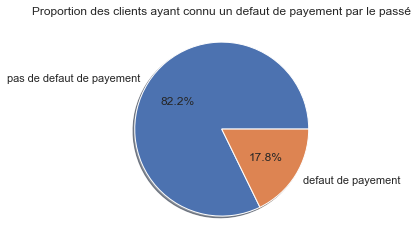

In [31]:
plt.figure()
ax = plt.axes()
ax.pie(loans.cb_person_default_on_file.value_counts(),
       labels=['pas de defaut de payement', 'defaut de payement'],
       autopct='%1.1f%%',
       shadow=True
)
plt.title('Proportion des clients ayant connu un defaut de payement par le passé')
plt.show()

Parmi ces ~18% des clients ayant eu un defaut de payement par le passé, combien ont récidivé? 

In [32]:
ct = pd.crosstab(loans.cb_person_default_on_file, loans.loan_status)
ct['prop_defaut_payement'] = ct[1]/ct.sum(axis=1)
ct

loan_status,0,1,prop_defaut_payement
cb_person_default_on_file,,,
N,21340,4711,0.180838
Y,3514,2114,0.375622


37,6% ont récidivé.

## cb_person_cred_hist_length

In [33]:
loans[['cb_person_cred_hist_length']].describe().T

,count,mean,std,min,25%,50%,75%,max
cb_person_cred_hist_length,31679.0,5.809211,4.05971,2.0,3.0,4.0,8.0,30.0


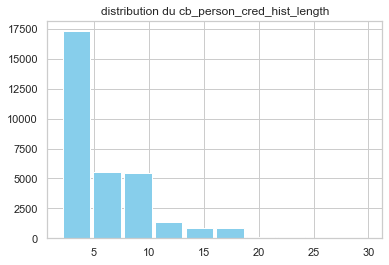

In [34]:
plt.figure()
plt.title("distribution du cb_person_cred_hist_length")
plt.hist(loans.cb_person_cred_hist_length, rwidth=.9, color='skyblue', bins=10)
plt.show()

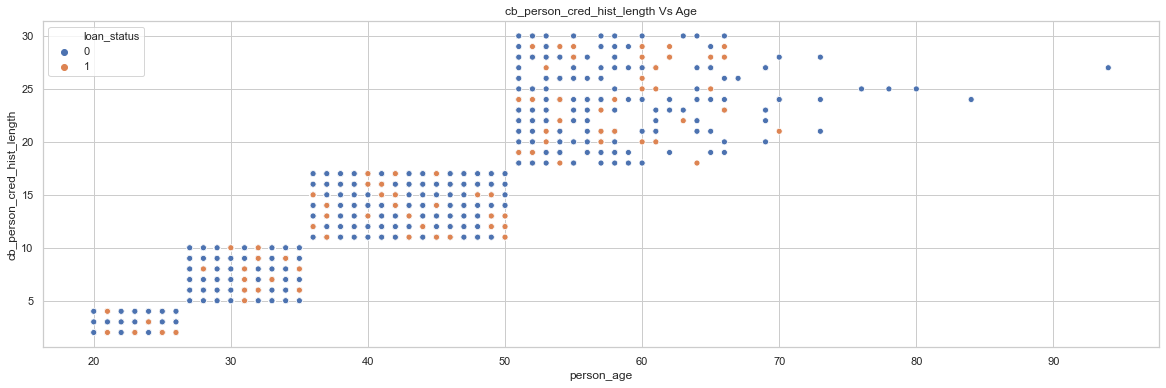

In [35]:
plt.figure(figsize=(20,6))
plt.title('cb_person_cred_hist_length Vs Age')
sns.scatterplot(loans.person_age, loans.cb_person_cred_hist_length, hue=loans.loan_status)
plt.show()

On voit que selon la tranche d'age, cb_person_cred_hist_length evolue dans le même range. 

# Etude de la correlation entre les variables explicatives

<Figure size 432x288 with 0 Axes>

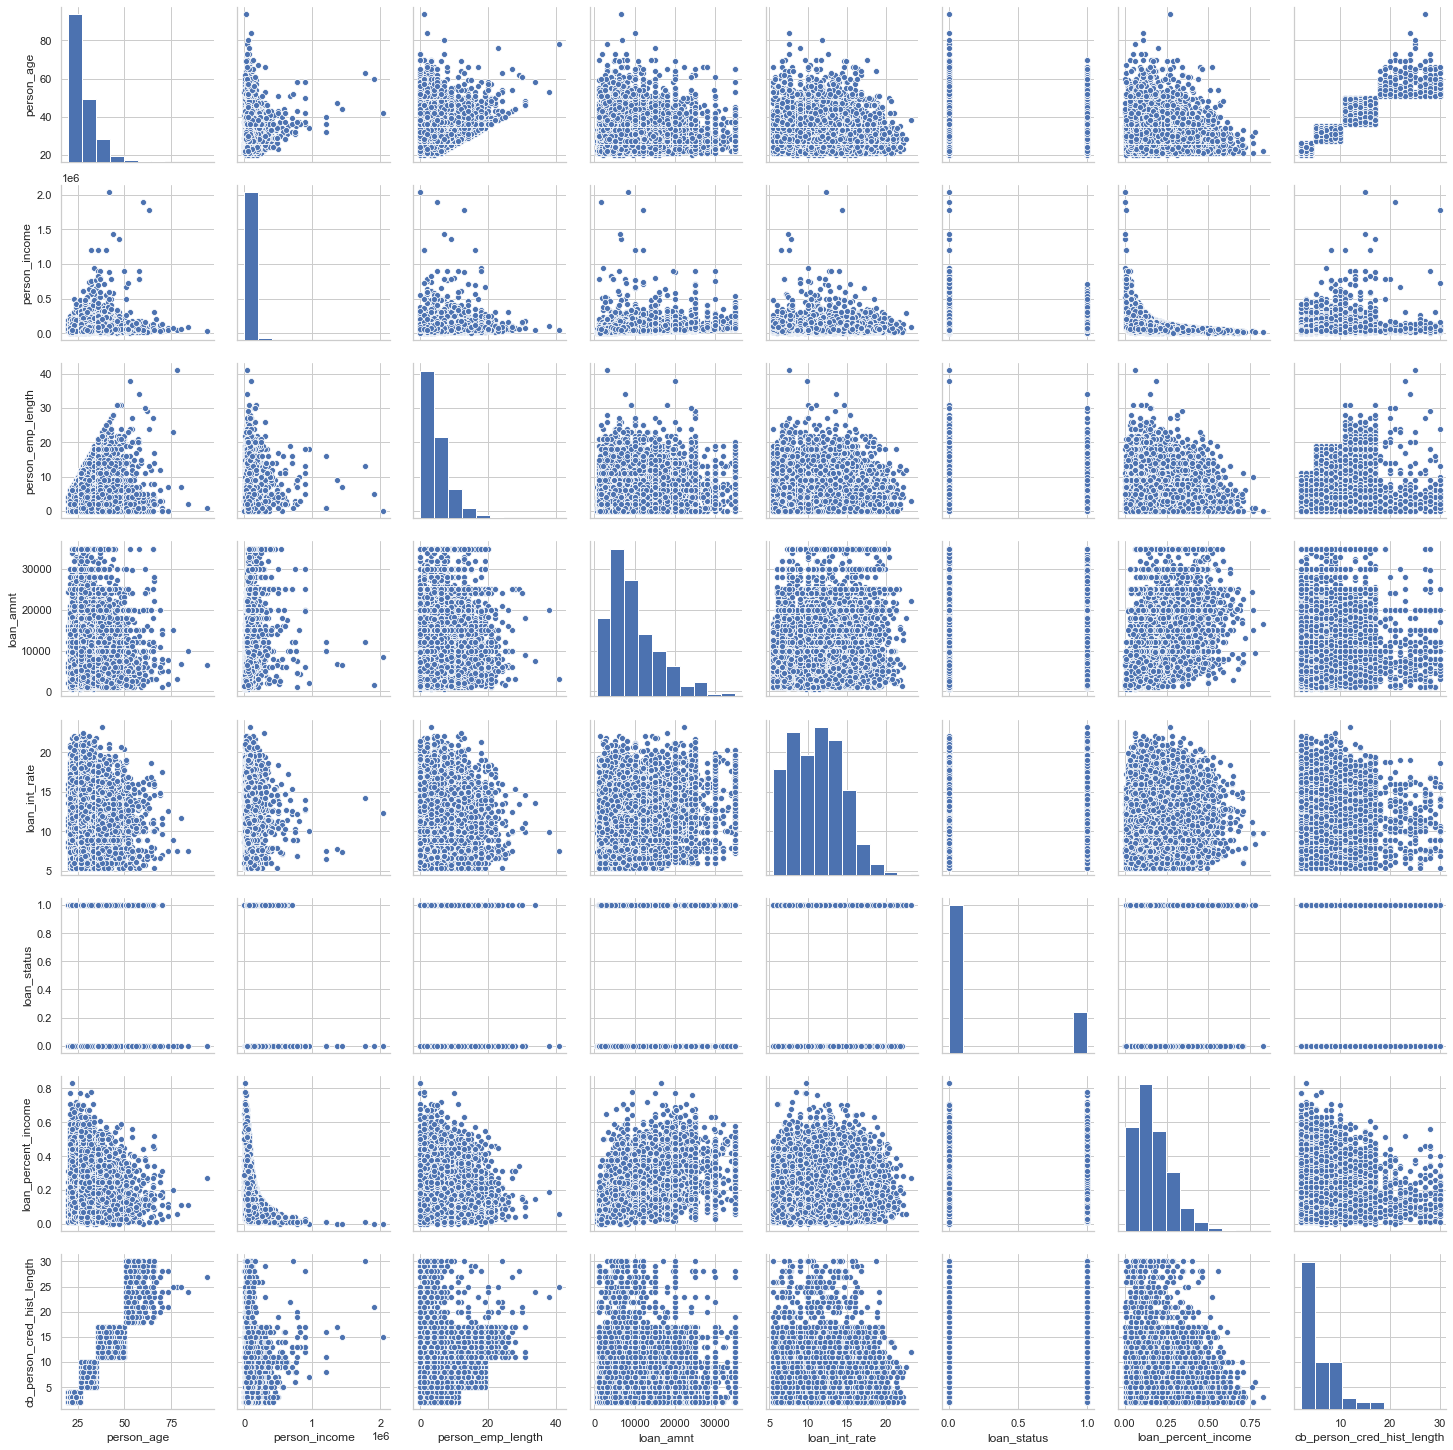

In [36]:
plt.figure()
sns.set(style="whitegrid", font_scale=1)
sns.pairplot(loans)
plt.show()

In [37]:
def get_corr_pairs(df, thresh=0.8):
    corr_ = df.corr()
    corr_ = corr_.apply(np.abs)
    
    # get only upper part of correlation matrix to avoid having duplicate pairs
    mask = np.triu(np.ones_like(corr_, dtype=np.bool))
    np.fill_diagonal(mask, 0)
    mask_df = pd.DataFrame(mask, columns=corr_.columns, index=corr_.columns)
    corr_ = corr_[mask_df].fillna(value=0)
    
    # iterate and compute duplicate pairs
    corr_pair = []
    for column, serie in corr_.iteritems():
        for index, value in serie.iteritems():
            if value>thresh:
                corr_pair.append((index, column))
                
    return corr_pair

In [38]:
get_corr_pairs(loans)

[('person_age', 'cb_person_cred_hist_length')]

Les deux variables ci-dessous sont fortement correlés, peut être que le modèle performera mieux si on supprimer l'une d'entre elles.

## Etude de la dependance entre la variable dependante loan_status et les variables explicatives

## loan_status Vs les variables numériques
Pour évaluer la correlation entre loan_status et les variables numérque, on utilisera le coefficient de Pearson.

In [39]:
def plot_corr_matrix(df):
    
    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15,10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    

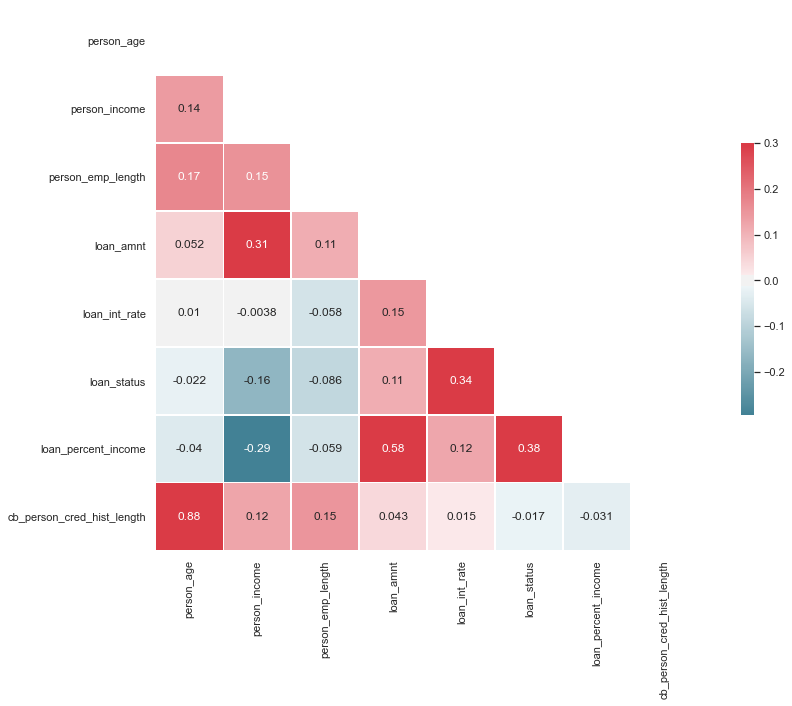

In [40]:
plot_corr_matrix(loans)

Les variables `person_age`, `person_income` et `loan_amnt` sont très peu correlé avec la varaible qu'on essay de prédire `loan_status`. Peu être que le modèle performera mieux si on les suprime.

## loan_status Vs les variables de categorie
Pour cela on utilisera le test de khi2 et les tables de contingence.

In [41]:
from scipy import stats
def is_feature_important(feature, target, alpha=.05):
    crosstable = pd.crosstab(target,feature) 
    chi2, p, dof, expected = stats.chi2_contingency(crosstable.values)
    
    return p < alpha

In [42]:
is_feature_important_report = {}
for col, serie in loans.select_dtypes('object').iteritems():
    is_feature_important_report[col] = is_feature_important(serie, loans.loan_status, alpha=.05)

is_feature_important_report 

{'person_home_ownership': True,
 'loan_intent': True,
 'loan_grade': True,
 'cb_person_default_on_file': True}

Selon le test de Khi2, les variables ci-dessous sont toutes correlées avec la cible (on est confiant à 95%).

## Les valeurs manquantes

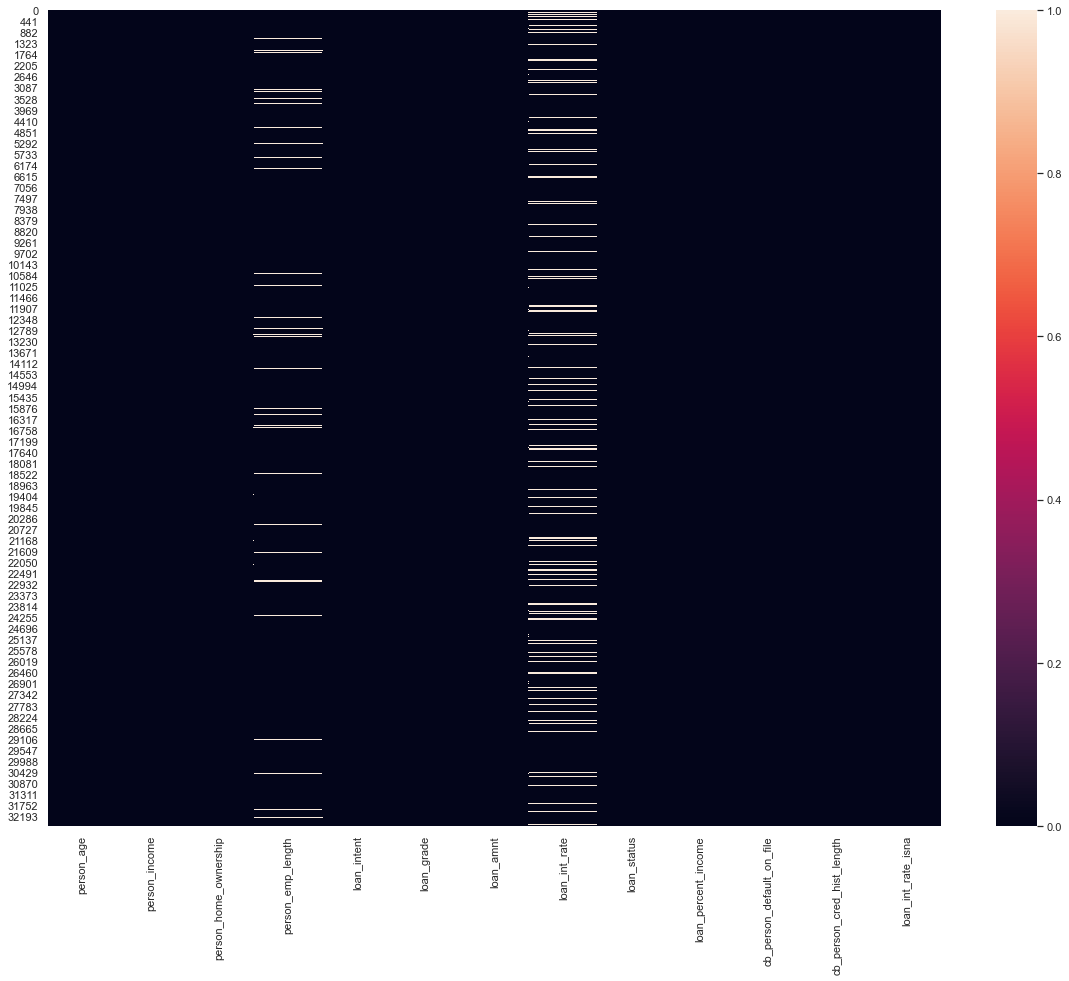

In [98]:
plt.figure(figsize=(20,15))
sns.heatmap(loans.isna())
plt.show()

Les valeurs manquantes sont concentrées principalement dans la variable `loan_int_rate`. Cette dernière est la deuxième variable la plus correlé avec `loan_status` (score de Pearson s'élevant à 0.34).

La stratégie que je vais adopter est d'imputer cette variable avec le taux d'intérêt moyen et créer une nouvelle variable binaire qui prendre la valeur de 1 à l'emplacement des valeurs manquantes.

On adoptera la même strategie avec la variable `person_emp_length`

In [106]:
loans['loan_int_rate_isna'] = loans.loan_int_rate.isna()
loans['person_emp_length_isna'] = loans.person_emp_length.isna()

## Feature importance

objectif: connaitre l'importance de chaque feature selon sa contribution dans la prediction de la probabilité du défaut de payement.

In [107]:
from sklearn.model_selection import train_test_split
import pickle

SEED = 42

X = loans.drop(columns=['loan_status'])
y = loans.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED, test_size=.2)

with open('train_test_split.pkl', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)

[ColumnTransformer]  (1 of 3) Processing impute_misssing_values, total=   0.0s
[ColumnTransformer]  (2 of 3) Processing ordinal_encoder, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


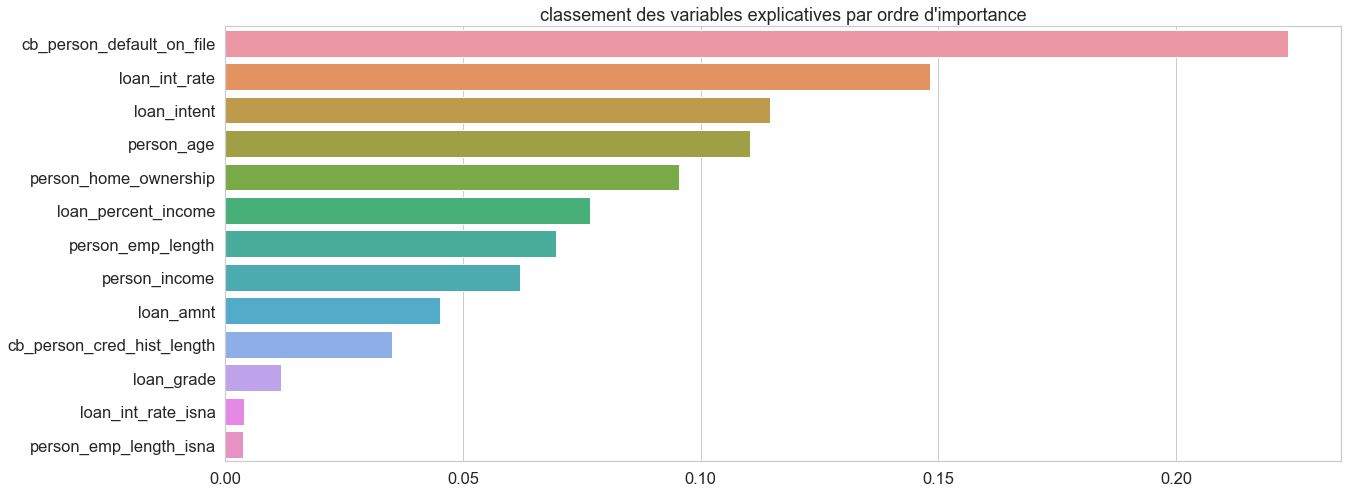

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

feature_engineering = ColumnTransformer([('impute_misssing_values', SimpleImputer(strategy='mean'), ['loan_int_rate', 'person_emp_length']),
                                         ('ordinal_encoder', OrdinalEncoder(), X_train.select_dtypes('object').columns.to_list())],
                                       remainder='passthrough', verbose=1)

# instanciate model
rf = RandomForestClassifier()
feature_engineering.fit(X_train, y_train)
rf.fit(feature_engineering.transform(X_train), y_train)

# get most importante features ID's
most_importante_features = X_train.columns[np.argsort(-rf.feature_importances_)]

# plot
plt.figure(figsize=(20,8))
sns.set(style="whitegrid", font_scale=1.5)
sns.barplot(y=most_importante_features, x= -1*np.sort(-rf.feature_importances_))
plt.title("classement des variables explicatives par ordre d'importance")
plt.show()

- la variable 'cb_person_default_on_file' semble être la plus importante pour determiner le risque de defaut de payement. L'age aussi semble être un facteur important ansi que le taux d'intêret de l'emprunt.

## Feature engineering

In [117]:
featutres_to_onehot = ['person_home_ownership', 'loan_intent']
features_to_label = ['cb_person_default_on_file']
features_to_ordinalencode = ['loan_grade']

feature_engineering = ColumnTransformer([('impute_misssing_values', SimpleImputer(strategy='mean'), ['loan_int_rate', 'person_emp_length']),
                                         ('OneHotEncoder', OneHotEncoder(drop='first'), featutres_to_onehot),
                                         ('LabelEncoder', OrdinalEncoder(), features_to_label),
                                         ('OrdinalEncoder', OrdinalEncoder(), features_to_ordinalencode)],
                                       remainder='passthrough', verbose=1)

## Modelisation

## Baseline model

On va commencer par un model linéaire, il s'agit de la regression logistique.

### Cross validation

In [118]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

mdl_params = {
    'random_state': SEED
}

cv = StratifiedKFold(5, shuffle=True, random_state=SEED)
model = Pipeline(steps=[('feature_engineering', feature_engineering),
                        ('scaling', StandardScaler()),
                        ('model', LogisticRegression(**mdl_params))]
                )
results = cross_validate(model, X_train, y=y_train, scoring='f1', cv=cv, return_train_score=True, verbose=10)

train = results['train_score'].mean()
validation = results['test_score'].mean()

train, validation

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[ColumnTransformer]  (1 of 5) Processing impute_misssing_values, total=   0.0s
[ColumnTransformer] . (2 of 5) Processing OneHotEncoder, total=   0.0s
[ColumnTransformer] .. (3 of 5) Processing LabelEncoder, total=   0.0s
[ColumnTransformer]  (4 of 5) Processing OrdinalEncoder, total=   0.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s
[CV] ................ , score=(train=0.602, test=0.586), total=   0.3s
[CV]  ................................................................
[ColumnTransformer]  (1 of 5) Processing impute_misssing_values, total=   0.0s
[ColumnTransformer] . (2 of 5) Processing OneHotEncoder, total=   0.0s
[ColumnTransformer] .. (3 of 5) Processing LabelEncoder, total=   0.0s
[ColumnTransformer]  (4 of 5) Processing OrdinalEncoder, total=   0.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ................ , score=(train=0.599, test=0.611), total=   0.2s
[CV]  ................................................................
[ColumnTransformer]  (1 of 5) Processing impute_misssing_values, total=   0.0s
[ColumnTransformer] . (2 of 5) Processing OneHotEncoder, total=   0.0s
[ColumnTransformer] .. (3 of 5) Processing LabelEncoder, total=   0.0s
[ColumnTransformer]  (4 of 5) Processing OrdinalEncoder, total=   0.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ................ , score=(train=0.602, test=0.586), total=   0.2s
[CV]  ................................................................
[ColumnTransformer]  (1 of 5) Processing impute_misssing_values, total=   0.0s
[ColumnTransformer] . (2 of 5) Processing OneHotEncoder, total=   0.0s
[ColumnTransformer] .. (3 of 5) Processing LabelEncoder, total=   0.0s
[ColumnTransformer]  (4 of 5) Processing OrdinalEncoder, total=   0.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV] ................ , score=(train=0.601, test=0.600), total=   0.2s
[CV]  ................................................................
[ColumnTransformer]  (1 of 5) Processing impute_misssing_values, total=   0.0s
[ColumnTransformer] . (2 of 5) Processing OneHotEncoder, total=   0.0s
[ColumnTransformer] .. (3 of 5) Processing LabelEncoder, total=   0.0s
[ColumnTransformer]  (4 of 5) Processing OrdinalEncoder, total=   0.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV] ................ , score=(train=0.594, test=0.613), total=   0.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


(0.5996498281188435, 0.5989896089170926)

- Le modèle n'arrive pas à capturer toute la complexité des données.
- Le modèle affiche une performance moyenne trés faible de 0.60.
- Le modèle n'affiche quasiment pas de variance, en revanche le peu de d'information qu'il a pu extraire se generalise bien.


Essayons maintenant le Boosting avec Lgbm pour voir si on arrive à battre ce score.

## Modelisation

## Cross validation

In [283]:
# drop loan_int_rate_isna and person_emp_length_isna since they are not very importante (see feature importance plot)
X = loans.drop(columns=['loan_status', 'loan_int_rate_isna', 'person_emp_length_isna'])
y = loans.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED, test_size=.2)

with open('train_test_split.pkl', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)

In [284]:
from sklearn.base import BaseEstimator

class CountEncoder(BaseEstimator):

    def __init__(self, normalize=True):
        self.normalize = normalize

    def fit(self, X_train, y=None):
        self.__set_mapping(X_train)
        
        return self

    def transform(self, X):
        X_tr = X.copy()

        if type(X) != type(pd.DataFrame()): 
            raise ValueError(f'{type(X)} not supported')
        
        col_id = 0
        for col, serie in  X.iteritems():
            X_tr[col] = serie.map(self.mapping_list[col_id])
            col_id += 1
        
        return X_tr

    def __set_mapping(self, X):
        if type(X) != type(pd.DataFrame()):
            raise ValueError(f'{type(X)} not supported')

        self.mapping_list = []
        for col, serie in X.iteritems():
            if self.normalize:
                self.mapping_list.append((serie.value_counts()/serie.value_counts().max()).to_dict())
            else:
                self.mapping_list.append(serie.value_counts().to_dict())


In [290]:
from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
static_params = {
    'objective': 'cross_entropy',
    'n_estimators': 120
}

features_to_countencode = ['person_home_ownership', 'loan_intent']
features_to_label = ['cb_person_default_on_file']
features_to_ordinalencode = ['loan_grade']


def my_pipeline(hps): 
    
    steps = [('scaling', StandardScaler()),
             ('model', LGBMClassifier(**static_params, **hps))
            ]
    
    model = Pipeline(steps)
    
    return model

hp_space = {
    'over_sampling_params': {'sampling_strategy': hp.uniform('SMOTE_sampling_ratio', 0.35, 0.8)},
    'SMOTE_algo': {'type': hp.choice('type', ['SMOTE', 'ADASYN'])},
    'model': {      
        'max_depth': hp.choice('max_depth', list(range(3, 13))),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
        'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
        'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
        'reg_lambda':  hp.uniform('reg_lambda', 0.01, 0.4),
        'gamma': hp.uniform('gamma', 0.01, .7)
    } 
}

def make_red(string):    
    return f"\x1b[31m\"{string}\"\x1b[0m"

def make_greed(string):    
    return f"\033[92m\"{string}\"\x1b[0m"
     
def objective_func(hps):
    model = my_pipeline(hps['model'])
    n_splits = 5
    cv = StratifiedKFold(n_splits = n_splits)
    score_sum = 0
    print(f'----- new run id[{objective_func.trial_id}]-------------------------------------------')
    print('New parameters to be evaluated')
    print(make_greed(hps))
    train_score = []
    val_score = []

    for train_index, val_index in cv.split(X_train, y_train): 
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        # feature engineering
        feature_engineering = ColumnTransformer([('impute_misssing_values', SimpleImputer(strategy='mean'), ['loan_int_rate', 'person_emp_length']),
                                             ('CountEncoder', CountEncoder(), features_to_countencode),
                                             ('LabelEncoder', OrdinalEncoder(), features_to_label),
                                             ('OrdinalEncoder', OrdinalEncoder(), features_to_ordinalencode)],
                                           remainder='passthrough', verbose=0)
        
        feature_engineering.fit(X_train_fold, y_train_fold)
        
        if hps['SMOTE_algo']['type'] == 'SMOTE':
            # apply SMOTE to train set
            over_sampling_algo = SMOTE(random_state=SEED, **hps['over_sampling_params'])
        
        elif hps['SMOTE_algo']['type'] == 'ADASYN':
            # apply ADASYN to train set
            over_sampling_algo = ADASYN(random_state=SEED, **hps['over_sampling_params'])
        
            
        X_train_res, y_train_res = over_sampling_algo.fit_resample(feature_engineering.transform(X_train_fold),
                                                   y_train_fold)
        
        
        model.fit(X_train_res, y_train_res)
        train_score.append(f1_score(y_train_res, model.predict(X_train_res)))
        val_score.append(f1_score(y_val_fold, model.predict(feature_engineering.transform(X_val_fold))))
        
        
    print(f'---------------- F1 score: train-score: {make_red(np.mean(train_score))}, val-score: {make_red(np.mean(val_score))} -----------')   
    objective_func.trial_id += 1
    objective_func.hist_score.append([np.mean(train_score), np.mean(val_score)])
    return - np.mean(val_score)

In [291]:
trials = Trials()
objective_func.trial_id = 0
objective_func.hist_score = []

best_model = fmin(objective_func, 
                 hp_space, algo=tpe.suggest, max_evals=100, 
                     trials=trials, rstate=np.random.RandomState(SEED))

----- new run id[0]-------------------------------------------
New parameters to be evaluated                         
"{'SMOTE_algo': {'type': 'ADASYN'}, 'model': {'colsample_bytree': 0.6068408319909555, 'gamma': 0.4901926400199571, 'learning_rate': 0.057576612101387724, 'max_depth': 12, 'reg_alpha': 0.03693002294070564, 'reg_lambda': 0.3347264926028343, 'subsample': 0.4}, 'over_sampling_params': {'sampling_strategy': 0.7382337259131377}}"
---------------- F1 score: train-score: "0.9409297148989616", val-score: "0.8307058614557086" -----------
----- new run id[1]-------------------------------------------                    
New parameters to be evaluated                                                    
"{'SMOTE_algo': {'type': 'SMOTE'}, 'model': {'colsample_bytree': 0.5105588009394864, 'gamma': 0.2957418564150215, 'learning_rate': 0.13732811017109758, 'max_depth': 8, 'reg_alpha': 0.13841251345844446, 'reg_lambda': 0.3439851054833719, 'subsample': 0.6}, 'over_sampling_params': {'sa

New parameters to be evaluated                                                     
"{'SMOTE_algo': {'type': 'SMOTE'}, 'model': {'colsample_bytree': 0.4215149985074035, 'gamma': 0.3398458458338043, 'learning_rate': 0.1486786528824213, 'max_depth': 8, 'reg_alpha': 0.1817719321817504, 'reg_lambda': 0.011357831408289859, 'subsample': 0.6}, 'over_sampling_params': {'sampling_strategy': 0.7131600662582367}}"
---------------- F1 score: train-score: "0.9497986032610115", val-score: "0.8323662120057772" -----------
----- new run id[27]-------------------------------------------                    
New parameters to be evaluated                                                     
"{'SMOTE_algo': {'type': 'SMOTE'}, 'model': {'colsample_bytree': 0.5518591959515252, 'gamma': 0.552477086218633, 'learning_rate': 0.17979590849224597, 'max_depth': 11, 'reg_alpha': 0.08480432584926562, 'reg_lambda': 0.23436783008726447, 'subsample': 0.6}, 'over_sampling_params': {'sampling_strategy': 0.791908543543638

New parameters to be evaluated                                                     
"{'SMOTE_algo': {'type': 'ADASYN'}, 'model': {'colsample_bytree': 0.7502404471392857, 'gamma': 0.6910330001085532, 'learning_rate': 0.19118039486836963, 'max_depth': 8, 'reg_alpha': 0.1382093526834161, 'reg_lambda': 0.0802685932297534, 'subsample': 0.5}, 'over_sampling_params': {'sampling_strategy': 0.5996849841485438}}"
---------------- F1 score: train-score: "0.9455748210869126", val-score: "0.8320182539405311" -----------
----- new run id[53]-------------------------------------------                    
New parameters to be evaluated                                                     
"{'SMOTE_algo': {'type': 'SMOTE'}, 'model': {'colsample_bytree': 0.6131018074978816, 'gamma': 0.21075133849443856, 'learning_rate': 0.1793471195184958, 'max_depth': 4, 'reg_alpha': 0.029835418772223232, 'reg_lambda': 0.04691621657078962, 'subsample': 0.7}, 'over_sampling_params': {'sampling_strategy': 0.75121032756664

New parameters to be evaluated                                                     
"{'SMOTE_algo': {'type': 'SMOTE'}, 'model': {'colsample_bytree': 0.675886885218681, 'gamma': 0.5379127631613214, 'learning_rate': 0.16200887679526282, 'max_depth': 6, 'reg_alpha': 0.09663222678421485, 'reg_lambda': 0.2730072541060204, 'subsample': 0.5}, 'over_sampling_params': {'sampling_strategy': 0.6904699577660088}}"
---------------- F1 score: train-score: "0.9475614600743112", val-score: "0.8326406240677123" -----------
----- new run id[79]-------------------------------------------                    
New parameters to be evaluated                                                     
"{'SMOTE_algo': {'type': 'SMOTE'}, 'model': {'colsample_bytree': 0.4055958649776702, 'gamma': 0.4053328901433103, 'learning_rate': 0.09129050161086859, 'max_depth': 8, 'reg_alpha': 0.14371146868137594, 'reg_lambda': 0.13578199537413563, 'subsample': 0.6}, 'over_sampling_params': {'sampling_strategy': 0.7991159906533429

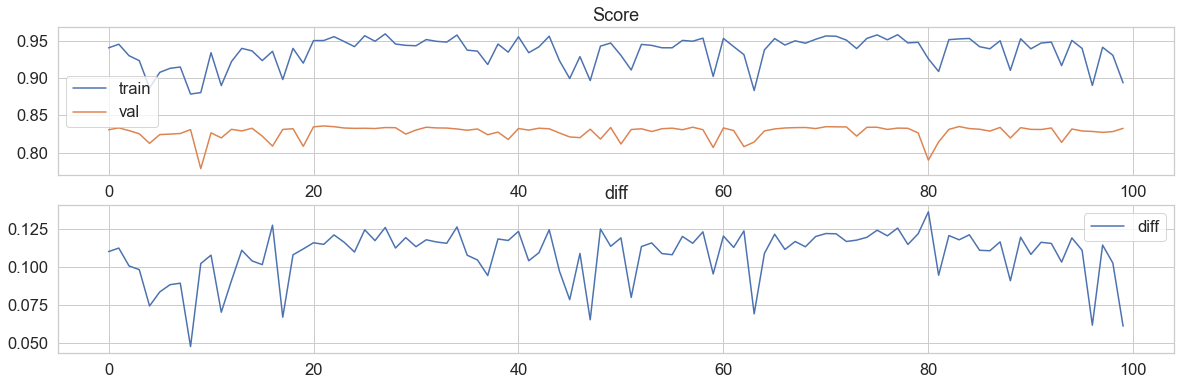

In [292]:
hist_score = np.array(objective_func.hist_score)

plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.plot(range(100),hist_score[:,0], label='train')
plt.plot(range(100),hist_score[:,1], label='val')
plt.title('Score')
plt.legend()

plt.subplot(2,1,2)
plt.title('diff')
plt.plot(range(100),hist_score[:,0] - hist_score[:,1], label='diff')
plt.legend()
plt.show()

In [293]:
hist_score = pd.DataFrame({'validation_score': hist_score[:,1], 'training_score': hist_score[:,0], 'diff':  hist_score[:,0]- hist_score[:,1]})
hist_score[hist_score['diff'] < 0.07].sort_values(by=['validation_score', 'diff'], ascending=[False, True]).head(20)

,validation_score,training_score,diff
99,0.832589,0.893838,0.061249
47,0.831445,0.896906,0.065461
17,0.831160,0.898314,0.067153
8,0.830887,0.878763,0.047876
96,0.828418,0.890363,0.061945
63,0.814189,0.883543,0.069355


On peut conclure que le modèle qui score le mieux sans trop overfitter est celui avec les parameters suivants:

{'SMOTE_algo': {'type': 'ADASYN'}, 'model': {'colsample_bytree': 0.5170775870438536, 'gamma': 0.4353118842914918, 'learning_rate': 0.1367018771045876, 'max_depth': 11, 'reg_alpha': 0.3554662749947996, 'reg_lambda': 0.2342274475354444, 'subsample': 0.6}, 'over_sampling_params': {'sampling_strategy': 0.3556514047629401}}

Pour notre modèle final, on sur échantillonnera la classe minoritaire en s'apuyant sur l'algo `ADASYN`. 

Validation score: **83.25%**


In [294]:
best_params = {'colsample_bytree': 0.5170775870438536, 'gamma': 0.4353118842914918,
               'learning_rate': 0.1367018771045876, 'max_depth': 11,
               'reg_alpha': 0.3554662749947996, 'reg_lambda': 0.2342274475354444,
               'subsample': 0.6}

best_sampling_strategy =0.3556514047629401

## Final model

In [295]:
lgbm_mdl = my_pipeline(best_params)

feature_engineering.fit(X_train, y_train)

over_sampling_algo = ADASYN(random_state=SEED, sampling_strategy=best_sampling_strategy)
X_train_res, y_train_res = over_sampling_algo.fit_resample(feature_engineering.transform(X_train),
                                                   y_train)
lgbm_mdl.fit(X_train_res, y_train_res)

[ColumnTransformer]  (1 of 5) Processing impute_misssing_values, total=   0.0s
[ColumnTransformer] . (2 of 5) Processing OneHotEncoder, total=   0.0s
[ColumnTransformer] .. (3 of 5) Processing LabelEncoder, total=   0.0s
[ColumnTransformer]  (4 of 5) Processing OrdinalEncoder, total=   0.0s
[ColumnTransformer] ..... (5 of 5) Processing remainder, total=   0.0s


Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 LGBMClassifier(colsample_bytree=0.5170775870438536,
                                gamma=0.4353118842914918,
                                learning_rate=0.1367018771045876, max_depth=11,
                                n_estimators=120, objective='cross_entropy',
                                reg_alpha=0.3554662749947996,
                                reg_lambda=0.2342274475354444,
                                subsample=0.6))])

In [296]:
from sklearn.metrics import classification_report

print('Train metrics')
print(classification_report(y_train_res, lgbm_mdl.predict(X_train_res)))
print('Test metrics')
print(classification_report(y_test, lgbm_mdl.predict(feature_engineering.transform(X_test))))

Train metrics
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     20378
           1       0.99      0.79      0.88      6555

    accuracy                           0.95     26933
   macro avg       0.96      0.89      0.92     26933
weighted avg       0.95      0.95      0.94     26933

Test metrics
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.97      0.73      0.83      1422

    accuracy                           0.94      6517
   macro avg       0.95      0.86      0.90      6517
weighted avg       0.94      0.94      0.93      6517



Le recall = TP/(TP + FN) = 0.73 -> pourcentage des vrais positifs que notre modèle arrive à attraper sur le total des vrais positifs dans le dataset de test.

Cela veux dire que sur un total de disant 4000 prêt de 500$ chacun présentant tous des défaut de payement. Notre modèle aurait pu en detecter `73%`(2920prêts), on aurait ainsi pu économiser 500*4000 - (4000-2920)*500 = `1.460m$`

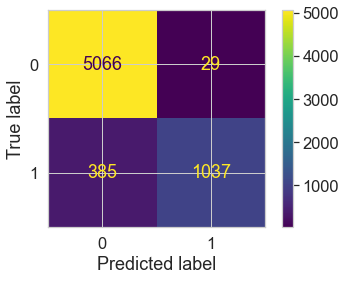

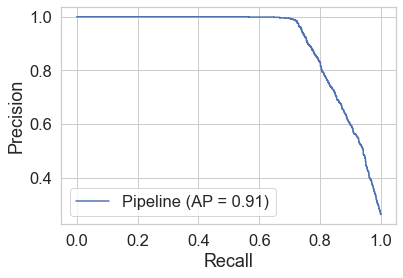

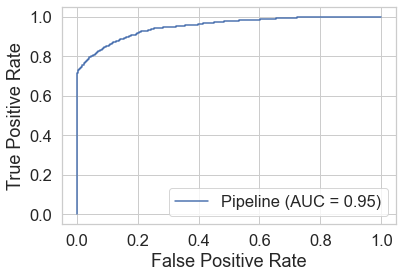

In [297]:
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

plot_confusion_matrix(lgbm_mdl, feature_engineering.transform(X_test), y_test);
plot_precision_recall_curve(lgbm_mdl, feature_engineering.transform(X_test), y_test);
plot_roc_curve(lgbm_mdl, feature_engineering.transform(X_test), y_test);

Le score AUC montre que notre modèle arrive à bien séparer les classes positives des classes négatives.
En revanche par defaut ces metrics acceptent par défaut un seuil de risque de 50%. 

In [352]:
from sklearn.base import ClassifierMixin

class CustomThreshold(BaseEstimator, ClassifierMixin):
    """ Custom threshold wrapper for binary classification"""
    def __init__(self, base, threshold=0.5):
        self.base = base
        self.threshold = threshold
    def fit(self, *args, **kwargs):
        self.base.fit(*args, **kwargs)
        return self
    def predict(self, X):
        return (self.base.predict_proba(X)[:, 1] > self.threshold).astype(int)

On peut maitenant definir le risque acceptable au dela duquel on classifie une demande comme présentant un défaut de paiement.

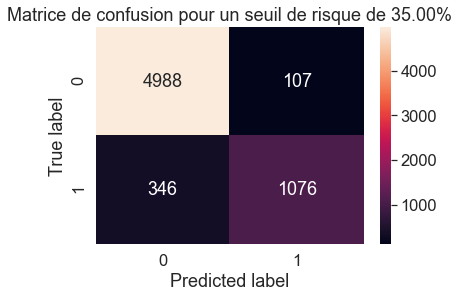

97.90% des bons debiteurs ont été détecté par le modèle.
75.67% des mauvais debiteurs ont été détecté par le modèle.

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5095
           1       0.91      0.76      0.83      1422

    accuracy                           0.93      6517
   macro avg       0.92      0.87      0.89      6517
weighted avg       0.93      0.93      0.93      6517



In [357]:
from sklearn.metrics import confusion_matrix

risk_threshold = 0.35

clf = CustomThreshold(lgbm_mdl, threshold=risk_threshold)

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(feature_engineering.transform(X_test))))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')

TN = confusion_matrix.iloc[0, 0]
FN = confusion_matrix.iloc[0, 1]
TP = confusion_matrix.iloc[1, 1]
FP = confusion_matrix.iloc[1, 0]

recall_1 = TP/(TP+FP)
recall_0 = TN/(TN+FN)
plt.title(f'Matrice de confusion pour un seuil de risque de {risk_threshold:.2%}')
plt.show()

print(f"{recall_0:.2%} des bons debiteurs ont été détecté par le modèle.")
print(f"{recall_1:.2%} des mauvais debiteurs ont été détecté par le modèle.\n")
print(classification_report(y_test, clf.predict(feature_engineering.transform(X_test))))

### prediction de la probabilité qu'un client presente un defaut de payement

In [298]:
# prenons un client du test set
client = pd.DataFrame(X_test.iloc[0])
client

,6616
person_age,22
person_income,50000
person_home_ownership,RENT
person_emp_length,6
loan_intent,PERSONAL
loan_grade,B
loan_amnt,6000
loan_int_rate,11.89
loan_percent_income,0.12
cb_person_default_on_file,N


Ce client est agé de `22ans` et gagne `75k$`, il demande un prêt de `5000$`. L'historique de ce client montre qu'il n'a jamais eu de defaut de paiement sachant qu'il a deja effectué 4 emprunts. Par conséquent, il est plutot bien noté, la banque lui accorde une note de `B`. **Quelle est la probabilité que ce client présente un defaut de paiement?**

In [314]:
f"{lgbm_mdl.predict_proba(feature_engineering.transform(client.T))[:,1][0]:.2%}"

'4.71%'

Selon notre model, ce client présente un risque de `4.7%`.

## save model

In [300]:
with open('models/model_lgbm_ADASYN.pkl', 'wb') as f:
    pickle.dump(lgbm_mdl, f)
    
with open('models/feature_engineering.pkl', 'wb') as f:
    pickle.dump(feature_engineering, f)   